# **시계열 분석 실습 과제**

기수: 22기
이름: 최해원

이 과제는 ARIMA 모델을 활용하여 2014년 6월 1일부터 2024년 6월 1일까지의 주가 데이터를 분석하고 예측하는 과정으로 구성되어 있습니다.

각 단계에서 필요한 코드를 실행하고, 빈칸을 채워 과제를 완성하세요.

---



- DataReader([종목정보],[데이터소스],[시작일],[종료일])
    - High(최고가)
    - Low(최저가)
    - Open(시가)
    - Close(종가)
    - Volume(거래량)
    - Adj Close (수정종가;분할,배당,배분,신주 발생이 된 경우를 고려하여 주식가격을 조정해둔 가격)

In [21]:
!pip install yfinance pmdarima matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## **1. 주가 데이터 수집 및 초기 탐색**

### **목표**
- Google의 주가 데이터를 Yahoo Finance에서 수집하여 기본적인 탐색적 데이터 분석을 수행합니다. 데이터의 구조와 특성을 이해하고, 시계열 분석의 기초를 마련합니다.
---

- **시작일**: `2014-06-01`
- **종료일**: `2024-06-01`
- **종목**: `GOOG`
---

### **지시사항**:
- 2014년 6월 1일부터 2024년 6월 1일까지의 Google 주가 데이터를 Yahoo Finance에서 불러오세요.
- 데이터를 다운로드한 후, 데이터의 첫 5행을 출력하세요.
- 데이터의 기초 통계 요약(평균, 표준편차, 최소값, 최대값 등)을 출력하여 데이터의 특성을 확인하세요.



In [22]:
# 시작일, 종료일 설정
start = '2014-06-01'
end = '2024-06-01'

# 데이터 다운로드
data = yf.download("GOOG", start=start, end=end)

# 데이터 확인: 첫 5행 출력
print(data.head())

# 데이터의 통계적 요약 확인
print(data.describe())

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-06-02  27.958241  27.968212  27.211790  27.620667  27.589272  28700582
2014-06-03  27.474070  27.541386  27.053225  27.172398  27.141512  37332215
2014-06-04  27.000870  27.355396  26.863747  27.158438  27.127567  36329469
2014-06-05  27.245197  27.671528  27.147964  27.619171  27.587778  33782496
2014-06-06  27.826603  27.826603  27.371351  27.740339  27.708807  34735104
              Open         High          Low        Close    Adj Close  \
count  2518.000000  2518.000000  2518.000000  2518.000000  2518.000000   
mean     74.181322    74.974861    73.452102    74.235356    74.150976   
std      39.945654    40.415505    39.536635    39.986349    39.940898   
min      24.664783    24.730902    24.311253    24.560070    24.532154   
25%      39.264999    39.561639    39.141300    39.316500    39.271811   
50%      59.266251    59

#### **참고사항**

**Yahoo Finance에서 가져온 데이터의 'Adj Close'와 'Close'의 차이는 무엇인가요? 왜 'Adj Close'를 분석에 사용하는 것이 중요한가요?**

- 'Close'는 주식 시장이 마감할 때의 주가를 의미하며, 'Adj Close'(Adjusted Close)는 주식의 분할, 배당, 배분 등과 같은 주식 이벤트를 반영한 수정 종가입니다.
- 'Adj Close'를 사용하는 것이 중요한 이유는 시간이 지남에 따라 주식 가격의 변동이 발생할 수 있기 때문입니다.
- 수정 종가는 이러한 이벤트를 고려한 후의 가격을 반영하므로, 장기적인 시계열 분석에서는 'Adj Close'를 사용하는 것이 더 정확한 분석을 가능하게 합니다.

##  **2. 데이터 전처리 및 시각화**

- 목표: 목표: 데이터의 품질을 향상시키기 위해 불필요한 데이터를 제거하고, 시계열 데이터의 기본적인 특성(추세 및 변동성)을 시각적으로 탐색합니다.

**지시사항** :
- 거래량(Volume)이 0인 일자는 데이터를 제거하여 품질을 향상시키세요.
- 수정종가(Adj Close) 데이터를 사용하여 50일 이동평균(Rolling Mean)과 이동표준편차(Rolling Standard Deviation)를 계산하세요.
- 원본 데이터와 함께 이동평균과 이동표준편차를 시각화하고, 시각화 결과를 바탕으로 시계열 데이터의 추세와 변동성에 대해 논의하세요.


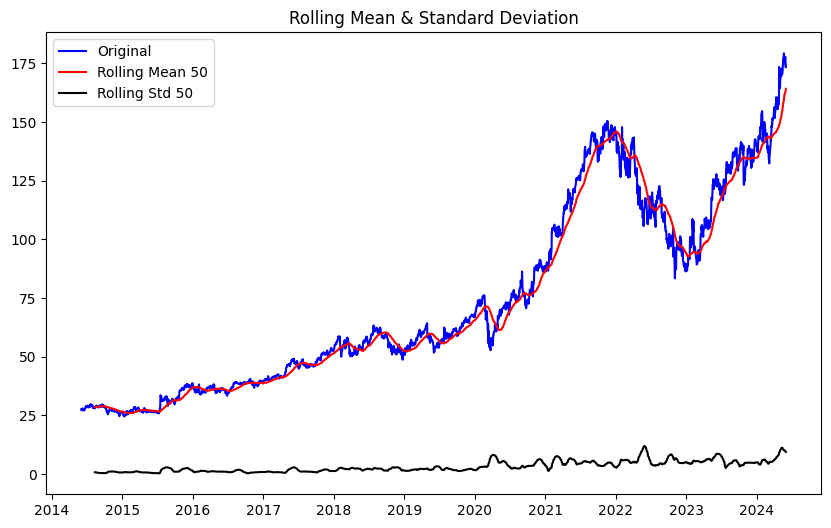

In [23]:
# 거래량이 0인 일자 제거 및 수정종가 데이터만 사용
data = data['Adj Close'][data['Volume'] != 0]

# 이동평균 및 이동표준편차 시각화 함수
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    plt.figure(figsize=(10, 6))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean {}'.format(interval))
    plt.plot(rolstd, color='black', label='Rolling Std {}'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# 50일치 이동평균 및 이동표준편차 계산
plot_rolling(data, interval= 50)


## **3. 시계열 데이터의 정상성 확인 - ADF 테스트**

### **목표**
시계열 데이터의 정상성 여부를 확인합니다. 정상성은 예측 모델을 적용하기 위한 필수 조건으로, 데이터를 적절히 변환하여 예측 모델이 더 잘 작동할 수 있도록 합니다.

### **지시사항**:

- ADF(Augmented Dickey-Fuller) 테스트를 사용하여 원본 데이터의 정상성 여부를 확인하세요.
- 1차 차분 데이터를 생성하고, 1차 차분 데이터에 대해 ADF 테스트를 수행하여 정상성 여부를 확인하세요.
- ADF 테스트의 p-value 결과를 바탕으로, 원본 데이터와 1차 차분 데이터의 정상성 여부를 논의하세요.


In [24]:
# ADF 테스트 함수 정의
def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    return result[1]

# ADF 테스트 수행 - 원본 데이터
print("ADF Test - 원본 데이터")
p_value_original = adf_test(data)  # 원본 데이터를 사용하세요.

# 1차 차분 데이터 생성 및 ADF 테스트 수행
dff1 = data.diff().dropna()
print("\nADF Test - 1차 차분 데이터")
p_value_diff1 = adf_test(dff1)  # 1차 차분 데이터를 사용하세요.

ADF Test - 원본 데이터
ADF Statistics: 0.797009
p-value: 0.991588

ADF Test - 1차 차분 데이터
ADF Statistics: -14.146945
p-value: 0.000000


## **4. ARIMA 모델 모수(p, d, q) 추정**
### **목표**
- ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function) 플롯을 사용하여 ARIMA 모델의 적절한 모수(p, d, q)를 추정합니다. 또한, Auto-ARIMA를 사용하여 모수를 자동으로 추정하고, 두 결과를 비교합니다.


### **지시사항**

- ACF와 PACF 플롯을 그려 p와 q 값을 추정하세요.
Auto-ARIMA를 사용하여 최적의 p, d, q 값을 자동으로 추정하세요.

- ACF와 PACF 플롯을 통해 p와 q 값을 추정하는 방법과 Auto-ARIMA의 결과가 일치하는지 논의하세요.




In [25]:
!pip install pmdarima

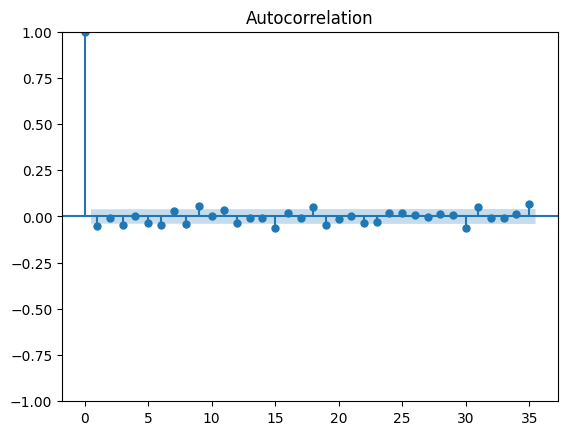

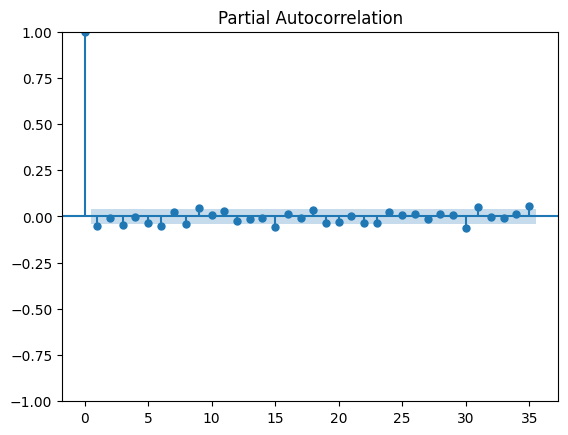

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2518
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4693.007
Date:                Mon, 09 Sep 2024   AIC                           9394.014
Time:                        09:41:14   BIC                           9417.337
Sample:                             0   HQIC                          9402.479
                               - 2518                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0134      0.007      1.848      0.065      -0.001       0.028
ar.L1          0.7702      0.068     11.347      0.000       0.637       0.903
ma.L1         -0.8157      0.062    -13.221      0.0

In [26]:
# ACF와 PACF 플롯 그리기
plot_acf(dff1)  # 1차 차분 데이터를 사용하세요.
plot_pacf(dff1)  # 1차 차분 데이터를 사용하세요.
plt.show()

# Auto-ARIMA를 사용한 모수 추정
model = pm.auto_arima(data, d=1, start_p=0, max_p=3, start_q=0, max_q=3, seasonal=False, stepwise=True)
print(model.summary())

### 5. ARIMA 모델 훈련 및 예측
**목표**
- ARIMA 모델을 사용하여 주가 데이터를 예측하고, 훈련된 모델의 성능을 평가합니다.

**지시사항**

- 데이터를 90%의 훈련 세트와 10%의 테스트 세트로 분리하세요.
- ARIMA 모델을 훈련시키고, 테스트 데이터에 대한 예측을 수행하세요.
- 예측 결과를 시각화하여 실제 값과 비교하세요.

**질문**

- 예측 결과가 실제 데이터와 얼마나 잘 일치하나요?
- 예측이 잘못된 부분이 있다면, 그 이유는 무엇일까요?



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2266
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4009.037
Date:                Mon, 09 Sep 2024   AIC                           8026.073
Time:                        10:19:43   BIC                           8048.975
Sample:                             0   HQIC                          8034.429
                               - 2266                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0105      0.008      1.334      0.182      -0.005       0.026
ar.L1          0.7510      0.085      8.869      0.000       0.585       0.917
ma.L1         -0.7920      0.079    -10.052      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


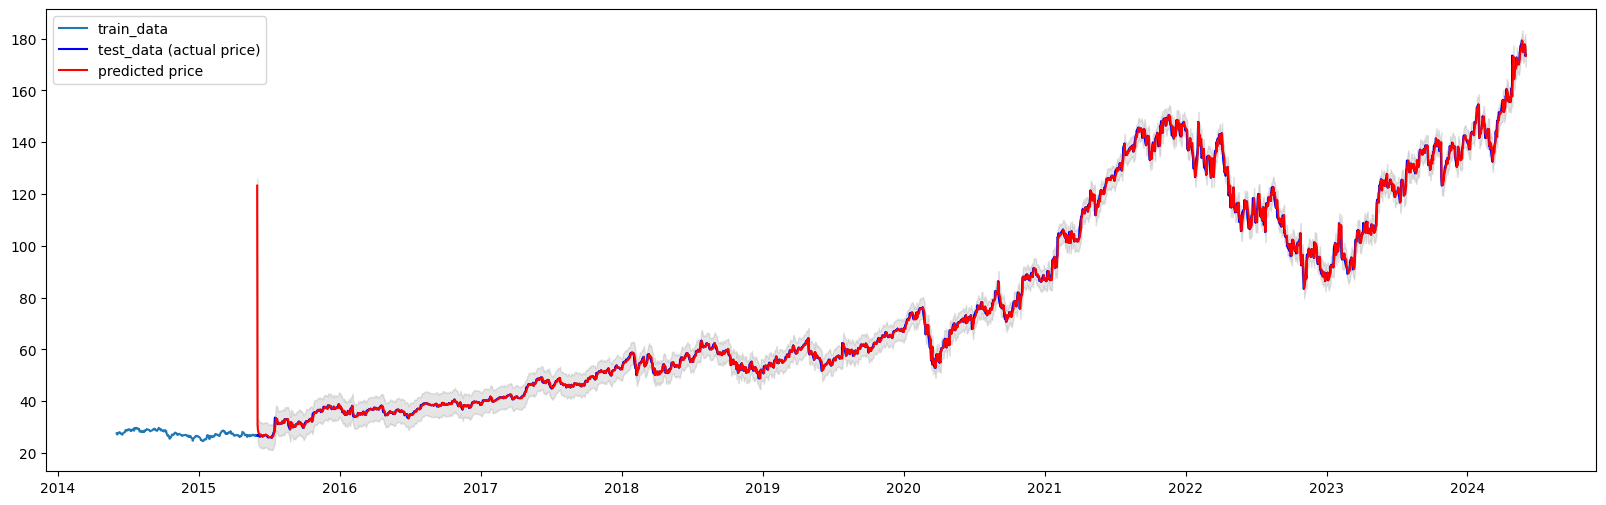

In [28]:
# Train/Test 데이터 분리
train_data, test_data = data[:int(len(data)*0.9)], data[int(len(data)*0.1):]

# ARIMA 모델 훈련
model_fit = pm.auto_arima(train_data, d=1, start_p=0, max_p=2, start_q=0, max_q=2, seasonal=False, stepwise=True)
print(model_fit.summary())

def forecast_n_step(model, n = 1):
  fc, conf_int = model.predict(n_periods = n, return_conf_int = True)
  return (
      fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
  )

def forecast(len, model, index, data):
  y_pred = []
  pred_upper = []
  pred_lower = []

  if data is not None:
    for new_ob in data:
      fc, conf = forecast_n_step(model)
      y_pred.append(fc[0])
      pred_upper.append(conf[0][1])
      pred_lower.append(conf[0][0])
      model.update(new_ob)
  else:
    for i in range(len):
      fc, conf = forecast_n_step(model)
      y_pred.append(fc[0])
      pred_upper.append(conf[0][1])
      pred_lower.append(conf[0][0])
      model.update(fc[0])

  return pd.Series(y_pred, index = index), pred_upper, pred_lower

# 예측 수행 및 결과 시각화
fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data=test_data)

plt.figure(figsize=(20, 6))
plt.plot(train_data, label='train_data')
plt.plot(test_data, c='b', label='test_data (actual price)')
plt.plot(fc, c='r', label='predicted price')
plt.fill_between(test_data.index, lower, upper, color='k', alpha=.10)
plt.legend(loc='upper left')
plt.show()


- 예측 결과  

  1. 예측 결과가 실제 결과와 유사.  
  2. 2015년에 큰 변동이 일어남. 이상치로 인한 오류로 추측.

## 6. 모델 평가 및 향후 1년 예측
**목표**
- ARIMA 모델의 예측 성능을 다양한 지표로 평가하고, 향후 1년간의 주가를 예측하여 시계열 데이터의 미래 동향을 분석합니다.

**지시사항**

- MSE, MAE, RMSE, MAPE를 계산하여 모델의 성능을 평가하세요.
- 향후 1년간의 주가를 예측하고, 예측 결과를 시각화하세요.


**질문**

- 평가 지표 중 가장 중요한 것은 무엇이라고 생각하나요? 그 이유는 무엇인가요?  
  : MAPE가 예측값이 실제값에 비해 얼마나 정확한지 크기가 아닌 비율로 나타내기 때문에 유용하다.
- 향후 1년간 예측한 주가를 기반으로 어떤 결론을 도출할 수 있나요?  
  : 지속적으로 상승하는 모양을 보아 앞으로도 계속 상승할 가능성이 높아보인다.

In [29]:
# 모델의 오차율 계산
mse = mean_squared_error(test_data, fc)  # 첫 번째 인수를 빈칸으로 남겨두세요.
mae = mean_absolute_error(test_data, fc)  # 첫 번째 인수를 빈칸으로 남겨두세요.

rmse = math.sqrt(mse)
mape = np.mean(np.abs(fc - test_data) / np.abs(test_data)) * 100

print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')

MSE: 6.83043982296557, MAE: 1.0754327910693942, RMSE: 2.6135110145100917, MAPE: 1.4178384024727444


# **추가 선택 과제: Prophet 모델을 활용한 시계열 분석**

Prophet은 Facebook에서 개발한 시계열 예측 모델로, 계절성과 트렌드 변화를 효과적으로 포착할 수 있도록 설계되어 있습니다. Prophet 모델은 사용이 쉽고 직관적인 파라미터 설정을 제공하여 비전문가도 쉽게 사용할 수 있는 장점이 있습니다. 이 과제는 Prophet 모델을 사용하여 Google 주가 데이터를 분석하고 예측하는 과제입니다.

**과제 목표**: Prophet 모델을 사용하여 2014년 6월 1일부터 2024년 6월 1일까지의 Google 주가 데이터를 분석하고, 향후 1년간의 주가를 예측합니다.

## **문제 1: 주가 데이터 수집 및 전처리**

1. Yahoo Finance에서 Google의 주가 데이터를 수집하세요. (기간: 2014년 6월 1일 ~ 2024년 6월 1일)
2. 'Adj Close' 열만 사용하여 Prophet 모델이 요구하는 포맷(ds, y)으로 데이터를 변환하세요.
3. 변환된 데이터의 첫 5행을 출력하여 확인하세요.

## **문제 2: Prophet 모델 학습**

1. Prophet 모델을 초기화하고 계절성, 트렌드, 주기성을 자동으로 감지할 수 있도록 설정합니다.
2. 모델을 주가 데이터에 적합(fit)시키세요.
3. 모델 학습이 완료된 후, 요약 결과를 출력하여 확인하세요.

## **문제 3: 미래 주가 예측**

1. 향후 1년간의 미래 데이터를 예측하기 위해, 예측할 날짜를 생성하세요.
2. 학습된 Prophet 모델을 사용하여 미래 데이터를 예측하세요.
3. 예측 결과를 시각화하고, 추세와 불확실성 범위를 함께 표시하세요.

## **문제 4: 모델 성능 평가**

1. 테스트 데이터(예: 마지막 10% 데이터)를 실제 값과 예측 값으로 분리하세요.
2. MSE, MAE, RMSE, MAPE를 계산하여 모델의 예측 성능을 평가하세요.
3. 예측 성능 평가 결과를 해석하고, Prophet 모델의 장단점에 대해 논의하세요.

## **문제 5: 결론 및 추가 분석**

1. Prophet 모델의 예측 결과를 바탕으로, 향후 1년간의 Google 주가에 대해 결론을 도출하세요.
2. 추가적으로 고려할 요소(예: 외부 이벤트, 경제 지표 등)를 제시하고, 이러한 요소들이 예측 결과에 미칠 수 있는 영향을 논의하세요.
3. Prophet 모델의 장단점을 정리하고, ARIMA 모델과 비교하여 어떤 상황에서 Prophet 모델이 더 유리한지 설명하세요.

## **추가 질문**

1. Prophet 모델의 예측 정확도를 높이기 위해 추가할 수 있는 요소는 무엇인가요?
2. Prophet 모델은 비선형적인 패턴과 외부 요인을 잘 반영하는가요? 그 이유를 설명하세요.

---

## **과제 제출 방법**
- 위의 문제를 해결하고, 코드와 함께 해석 및 결론을 제출하세요.
- 추가적으로 Prophet 모델의 결과를 더 개선할 수 있는 방법에 대한 아이디어를 제안해 보세요.

이 과제는 시계열 분석에 대한 이해를 심화하고 Prophet 모델을 실제로 적용해 보고 싶은 분들을 위한 선택 과제입니다. 강의에서 다루지 않았지만, 시계열 데이터 분석의 다양한 가능성을 탐구하고 싶은 분들은 도전해 보세요! 😊
